# This code is intended to be used for offline analysis of the magnetic data retreived from the WebDAQ during site surveying.

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
from ipywidgets import FloatSlider
from ipywidgets import Layout 
from scipy import signal
from matplotlib import gridspec

################################################################################################################################
################################## This will be for the data you collect with the magnetometer #################################
####################### You'll have to remove the metadata from the csv file in order to run the script ########################
################################################################################################################################

mag = pd.read_csv(r"C:\Users\cacam\Downloads\Mag_proper.csv", delimiter=',')  

samples = mag['Sample']
times = mag['Time (s)']
noise = mag['Noise (V)']
k = mag['Voltage Z (V)']
j = mag['Voltage Y (V)']
i = mag['Voltage X (V)']

############################################ This is the sample rate we used in testing ########################################
mag_rate = 5120 
############################################# If you used something else, put it here ##########################################

## The following cell displays the time series of the recorded data

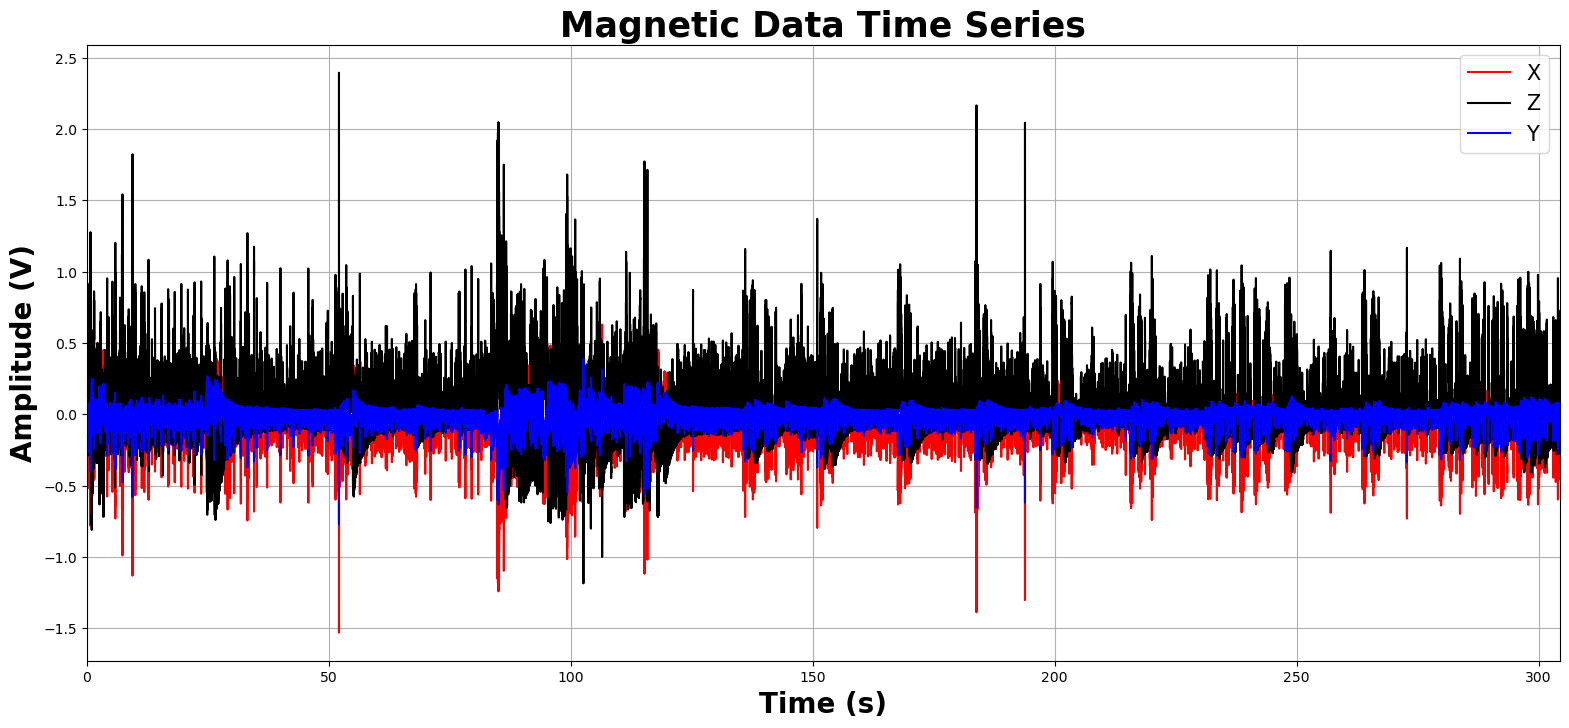

In [36]:
plt.figure(figsize = (19, 8))

####################### You can change the linestyle/order in which they are ploted for ease of viewing ########################

plt.plot(times,i, label = 'X', color = 'red', linewidth = 1.5)
plt.plot(times,k, label = 'Z', color = 'black', linewidth = 1.5)
plt.plot(times,j, label = 'Y', color = 'blue', linewidth = 1.5)
#plt.plot(times,noise, label = 'Noise', color = 'yellow', linewidth = 1.5)

plt.legend(loc = 'upper right', fontsize = 15)
plt.title("Magnetic Data Time Series", fontweight = 'bold', fontsize = 25)
plt.xlabel("Time (s)", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude (V)", fontweight = "bold", fontsize = 20)
plt.xlim(0,times[len(times)-1])
plt.grid(True)

## If you want to look at a specific time along the time series, you can use the slider plot below. Beware, there is a slight time delay,

In [35]:
Min = min(k.min(), j.min(), i.min())  ########################## This is to find the window height #############################
Max = max(k.max(), j.max(), i.max())

##################################### This function is what makes the slider run ###############################################
######################################### Parameters can be changed as needed ##################################################

def plot_with_slider(xlim):
    
    plt.figure(figsize=(19, 8))   ## dpi breaks slider
    
    plt.plot(times, i, linewidth = 1.5, label = 'X', color = 'red')
    plt.plot(times, k, linewidth = 1.5, label = 'Z', color = 'black')
    plt.plot(times, j, linewidth = 1.5, label = 'Y', color = 'blue')
    
    plt.xlim(xlim, xlim + 15) ######################## This is how long the window is (CAN be changed) #########################
    plt.ylim(Min - 0.05 , Max + 0.25) ############ This adds a buffer to the window height (CAN be changed) ####################
    
    plt.legend(loc = 'upper right', fontsize = 15)
    plt.title("Electromagentic Data", fontweight = 'bold', fontsize = 25)
    plt.xlabel("Time (s)", fontweight = "bold", fontsize = 20)
    plt.ylabel("Amplitude (V)", fontweight = "bold", fontsize = 20)
    
    plt.grid(True)
    plt.show()

######################################## This is where the slider plot gets plotted ############################################
#### min,max = start,end ; step is the increment it slides on ; value is where it starts ; layout is how long the slider is ####
############################################### step and layout CAN be changed #################################################

interact(plot_with_slider, xlim = FloatSlider(min = 0, max = (times[len(times)-1]), step = 3, value = 0, 
                                              layout=Layout(width='980px')))


interactive(children=(FloatSlider(value=0.0, description='xlim', layout=Layout(width='980px'), max=304.312305,…

<function __main__.plot_with_slider(xlim)>

## This will determine how large a bin you wish to use for your power spectral density plot/calculations

In [7]:
############################### Enter how long of a time segment you'd like to calculate with ##################################
start = 0  ## In terms of seconds
end = 100

a = 0 ################################################# Variables for loops ####################################################
b = 0 

################################################################################################################################
############################# This loop is for selecting only the start-end data from the file #################################

for a in range(0, len(times)): ############### These are to find the index values of start,end from the data file ##############
    if round(times[a]) == start:
        alpha = samples[b]
        break
        
for b in range(0, len(times)):
    if round(times[b]) == end:
        beta = samples[b]
        break

################################################### The data gets sliced #######################################################

t = times[alpha:beta]
#ns = noise[alpha:beta]
k1 = k[alpha:beta]
j1 = j[alpha:beta]
i1 = i[alpha:beta]

## This cell is where the PSD is calculated and plotted

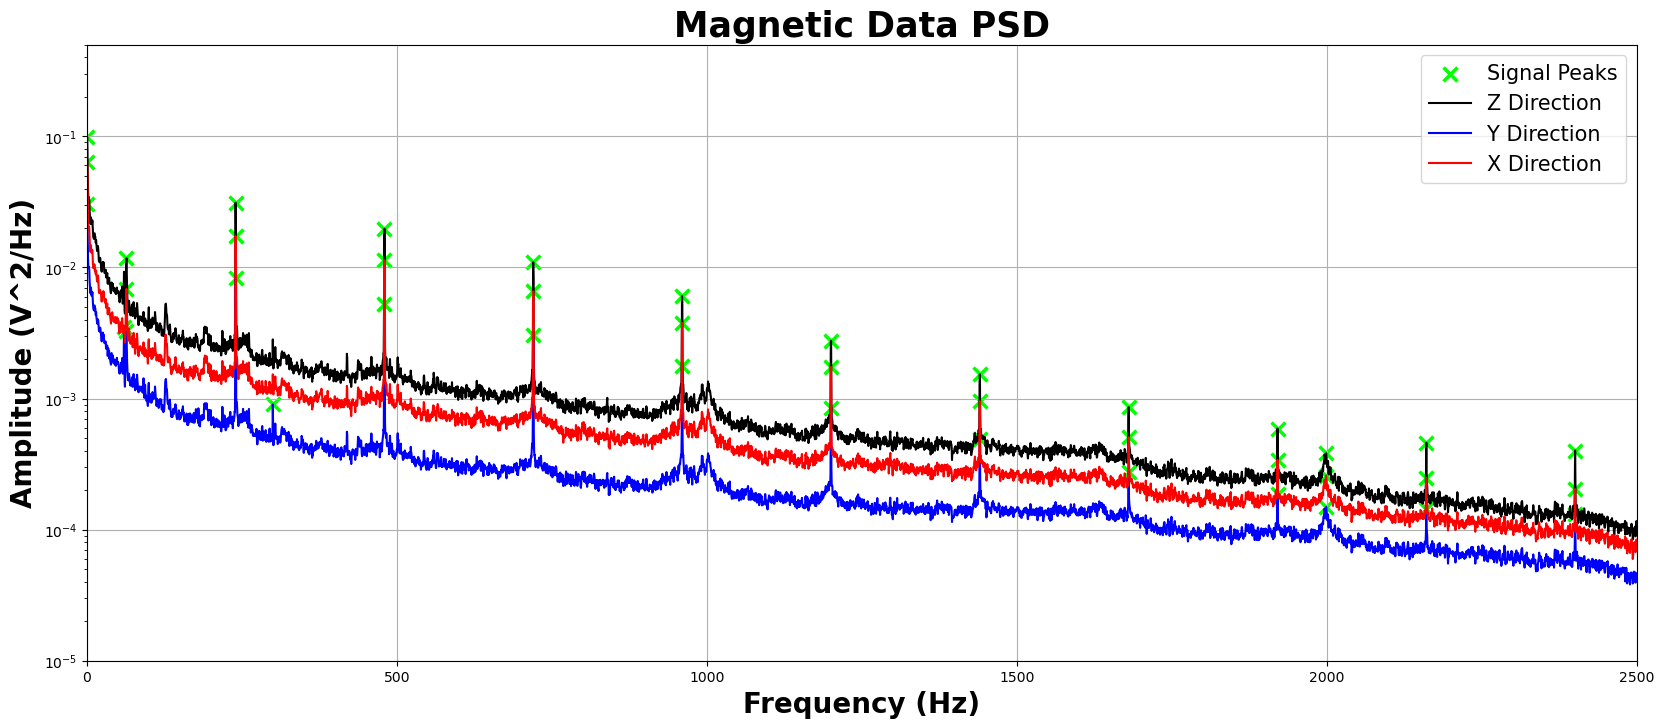

In [74]:
################################################################################################################################
########################################## The PSD is calculated via welch from scipy ##########################################
################################################################################################################################

################### If you want to look at the whole time series, you can remove the '1' from k1, j1, i1 #######################
f_k, Pxx_den_k = signal.welch(k1, mag_rate, window='hamming', nperseg= (mag_rate * 2)) # If need be, you can change the window #
f_j, Pxx_den_j = signal.welch(j1, mag_rate, window='hamming', nperseg= (mag_rate * 2)) ###############   HOWEVER   #############
f_i, Pxx_den_i = signal.welch(i1, mag_rate, window='hamming', nperseg=(mag_rate * 2))  ### do not change the other variables ###
                                                                                       

l_k = np.log(Pxx_den_k)
l_j = np.log(Pxx_den_j) ############# The log of each PSD must be found in order to find the peaks/frequences ##################
l_i = np.log(Pxx_den_i)


peaks_k, _ = signal.find_peaks(l_k, prominence = 1.2) ############# This is where the frequencies are found ####################
peaks_j, _ = signal.find_peaks(l_j, prominence = 1.2) ############## If some are missed or there are extra #####################
peaks_i, _ = signal.find_peaks(l_i, prominence = 1.2) ######### you will need to change the prominence variable ################


################################################################################################################################
##################################################### Plots peaks ##############################################################

plt.figure(figsize = (20, 8)) 

plt.scatter(f_k[peaks_k], Pxx_den_k[peaks_k] ** 0.5, s = 100, color = 'lime', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')
plt.scatter(f_j[peaks_j], Pxx_den_j[peaks_j] ** 0.5, s = 100, color = 'lime', marker = 'x', 
            linewidths = 2.5)
plt.scatter(f_i[peaks_i], Pxx_den_i[peaks_i] ** 0.5, s = 100, color = 'lime', marker = 'x', 
            linewidths = 2.5)

###################################################### PLots data ##############################################################

plt.semilogy(f_k, Pxx_den_k ** 0.5, color = 'black', linewidth = 1.5, label = 'Z Direction')
plt.semilogy(f_j, Pxx_den_j ** 0.5, color = 'blue', linewidth = 1.5, label = 'Y Direction')
plt.semilogy(f_i, Pxx_den_i ** 0.5, color = 'red', linewidth = 1.5, label = 'X Direction')

plt.legend(loc = "upper right", fontsize = 15)
plt.title("Magnetic Data PSD", fontweight = 'bold', fontsize = 25)
plt.xlabel("Frequency (Hz)", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude (V^2/Hz)", fontweight = "bold", fontsize = 20)
plt.ylim(10e-6, 0.5)
plt.xlim(0, 2500)
plt.grid(True)


## The following cell will plot each of direction signal in their own respective plots
### If you don't want/need to look at them individually, you don't have to run it

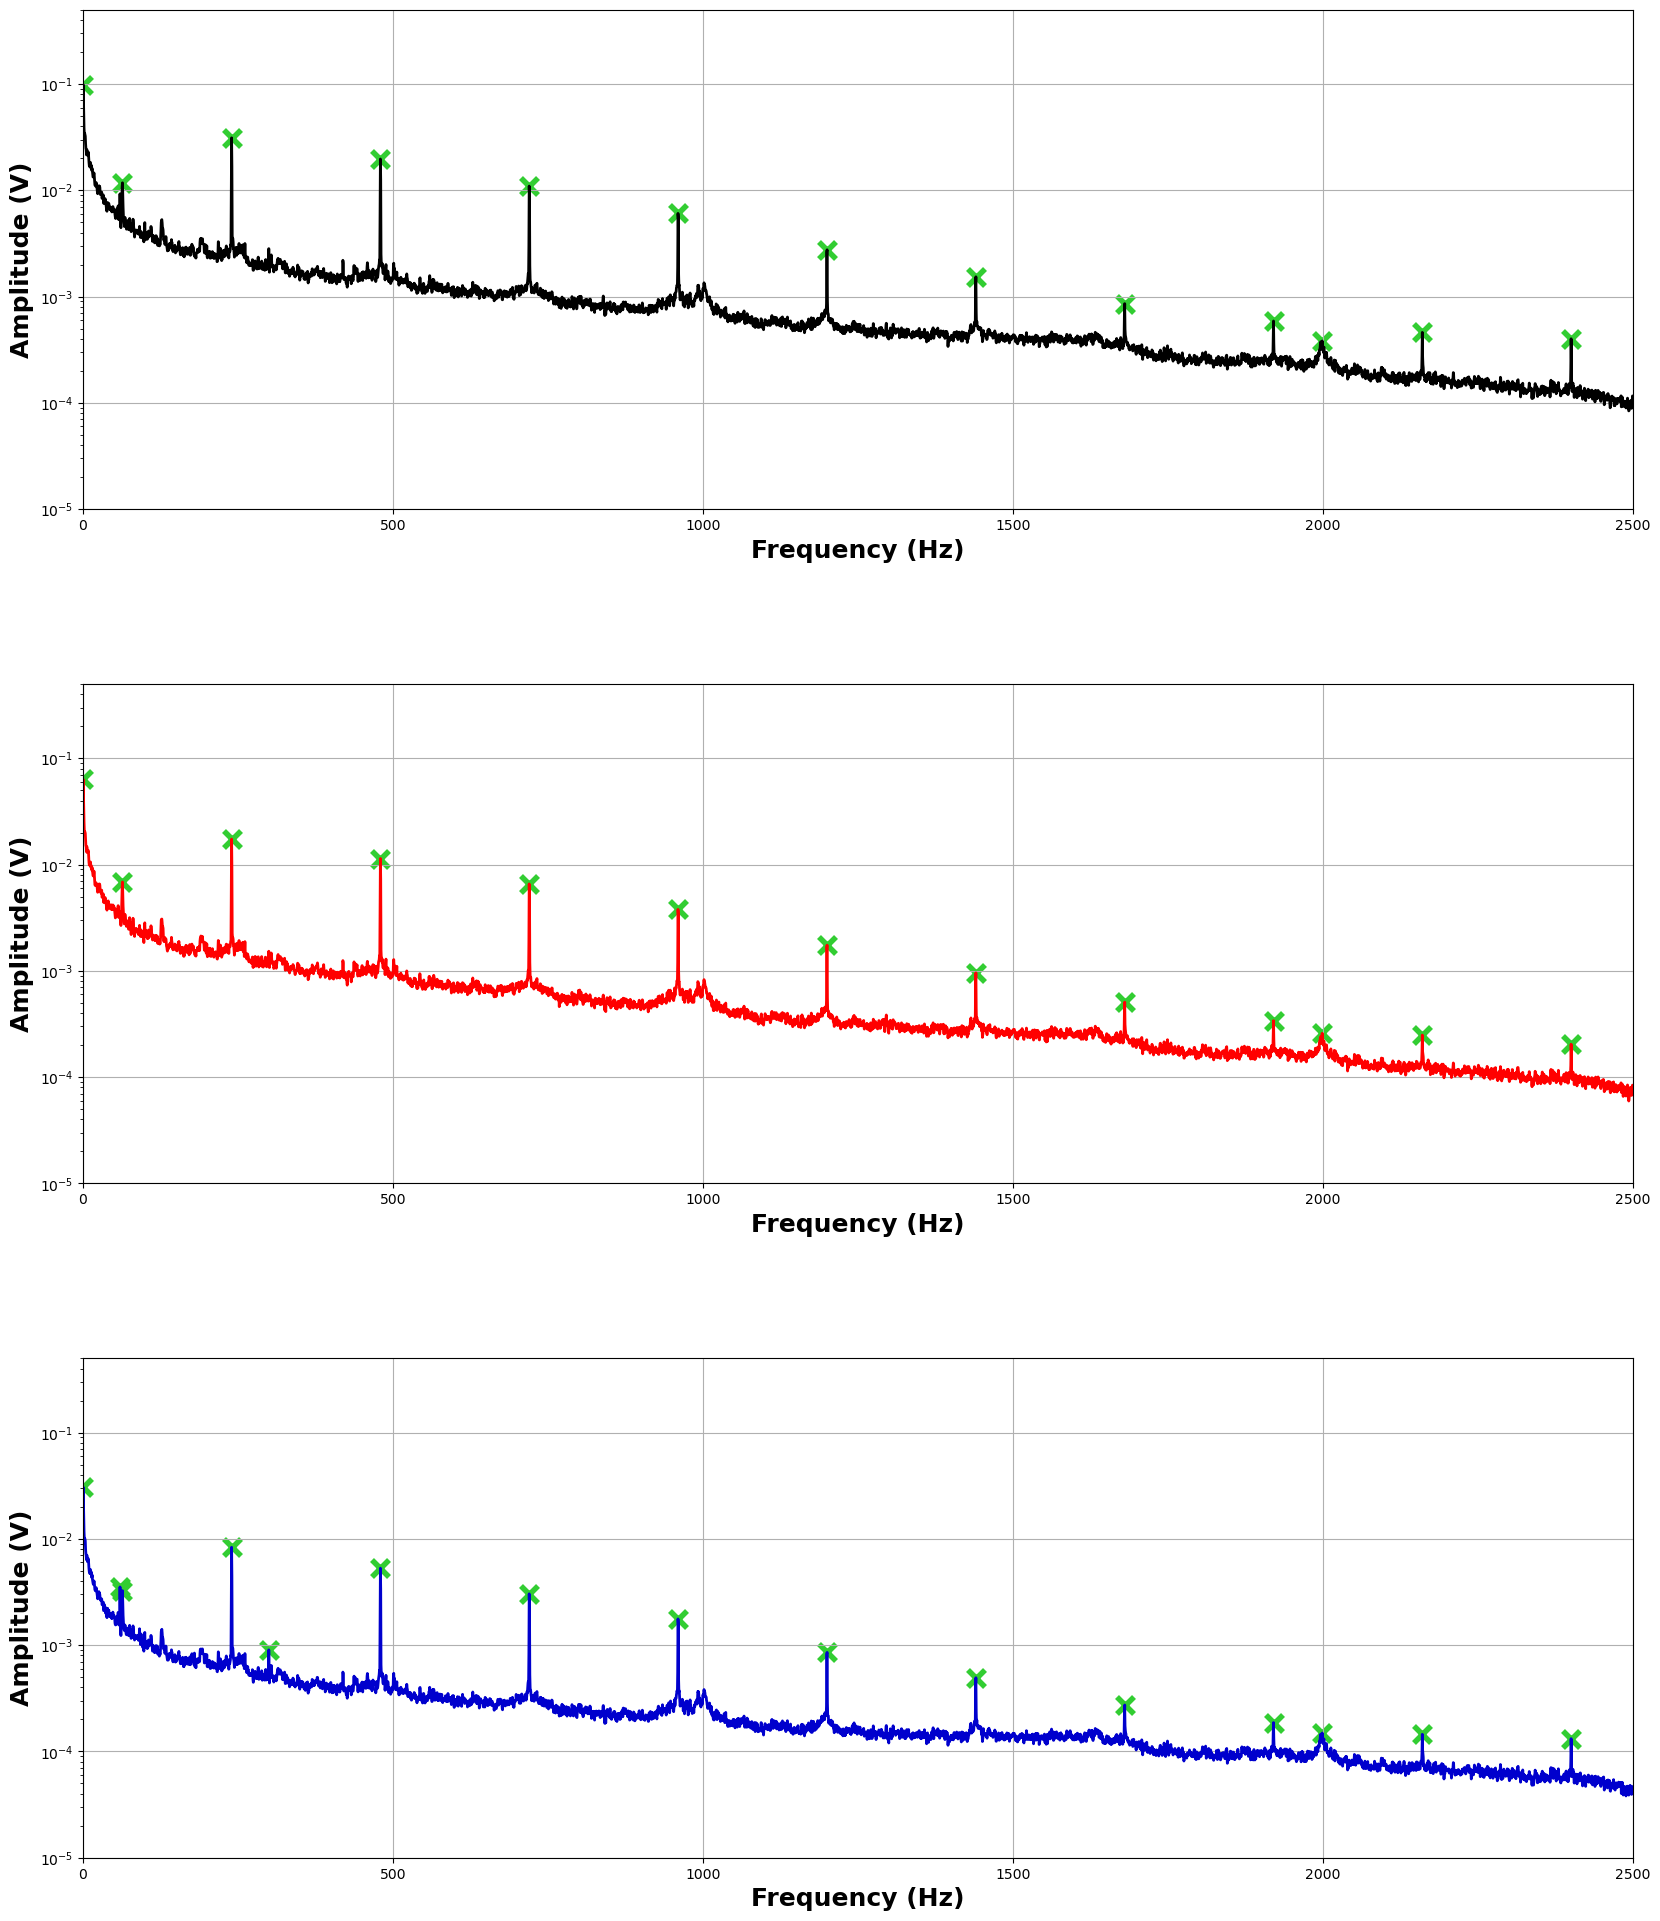

In [9]:
################################################################################################################################
############################# This gets plotted as a multipanel plot via gridspec and subplot ##################################
################################################################################################################################

fig = plt.figure(figsize = (20,24))

gs = gridspec.GridSpec(3,1, height_ratios = [1,1,1], hspace = 0.35)

####################################################### Channel Z ##############################################################

axis1 = fig.add_subplot(gs[0,0])

axis1.scatter(f_k[peaks_k], Pxx_den_k[peaks_k] ** 0.5, s = 150, color = 'limegreen', marker = 'x', 
              linewidths = 4, label = 'Signal Peaks')
axis1.semilogy(f_k, Pxx_den_k ** 0.5, color = 'black', linewidth = 2, label = 'Channel Z')

axis1.set_xlabel("Frequency (Hz)", fontweight = "bold", fontsize = 18)
axis1.set_ylabel("Amplitude (V)", fontweight = "bold", fontsize = 18)

axis1.set_ylim([10e-6, 0.5])
axis1.set_xlim(0, 2500)
axis1.grid(True)

######################################################## Channel X #############################################################

axis2 = fig.add_subplot(gs[1,0])

axis2.scatter(f_i[peaks_i], Pxx_den_i[peaks_i] ** 0.5, s = 150, color = 'limegreen', marker = 'x', 
              linewidths = 4)
axis2.semilogy(f_i, Pxx_den_i ** 0.5, color = 'red', linewidth = 2, label = 'Channel N')

axis2.set_xlabel("Frequency (Hz)", fontweight = "bold", fontsize = 18)
axis2.set_ylabel("Amplitude (V)", fontweight = "bold", fontsize = 18)

axis2.set_ylim([10e-6, 0.5])
axis2.set_xlim(0, 2500)
axis2.grid(True)

######################################################## Channel Y #############################################################

axis3 = fig.add_subplot(gs[2,0])

axis3.scatter(f_j[peaks_j], Pxx_den_j[peaks_j] ** 0.5, s = 150, color = 'limegreen', marker = 'x', 
              linewidths = 4)
axis3.semilogy(f_j, Pxx_den_j ** 0.5, color = 'mediumblue', linewidth = 2, label = 'Channel E')

axis3.set_xlabel("Frequency (Hz)", fontweight = "bold", fontsize = 18)
axis3.set_ylabel("Amplitude (V)", fontweight = "bold", fontsize = 18)

axis3.set_ylim([10e-6, 0.5])
axis3.set_xlim(0, 2500)
axis3.grid(True)

## This cell will output all the frequencies found and their respective amplitudes into a csv file

In [75]:
####################################################### # # # # # # ############################################################
################################################### # SPAGHETTI CODE # #########################################################
###################################################### # # # # # # # ###########################################################
################################################################################################################################
###################################### Since each direction has a different number of peaks ####################################
############################################### They cannot be printed out right ###############################################
########################################### So they have to be made the same length ############################################
################################################################################################################################

c = 0 ################################################## Variables for loops ###################################################
g = 0
h = 0
p = 0

lst = [] ############################################## Empty sets to be appended to ###########################################
tally = []
docket = []

badwolf = max(len(f_i[peaks_i]), len(f_j[peaks_j]), len(f_k[peaks_k])) # Finds the directions with the most peaks, i.e longest #

for g in range(0, badwolf - len(f_i[peaks_i])): ############# The shorter data sets will be made equal with 'Nan' ##############
    lst.append('NaN')                           #################### Nothing will happen to the longest set ####################
for h in range(0, badwolf - len(f_j[peaks_j])): ################# If they are the same length nothing happens ##################
    tally.append('NaN')
for p in range(0, badwolf - len(f_k[peaks_k])):
    docket.append('NaN')

######################################### This path is where the file gets outputted ###########################################
with open (r"C:\Users\cacam\Documents\Mag_frequencies.csv",'w') as f: ####################### Change as need ###################
        f.write('Frequency_X (Hz), Amplitude_X (V), Frequency_Y (Hz), Amplitude_Y (V), Frequency_Z (Hz), Amplitude_Z (V)\n') 

        for c in range(0, badwolf):
            if (len(f_i[peaks_i]) != len(f_j[peaks_j]) != len(f_k[peaks_k])):
                if len(f_i[peaks_i]) == badwolf:
                    
############################################# The files are made the same length ###############################################
                    
                    dir1 = np.append(f_j[peaks_j], tally)
                    dir_1 = np.append(Pxx_den_j[peaks_j], tally)
                    dir2 = np.append(f_k[peaks_k], docket)
                    dir_2 = np.append(Pxx_den_k[peaks_k], docket)

##################################### This where the dat points get printed in the file ########################################
                   
                    f.write(str(f_i[peaks_i][c]) + ',' + str(Pxx_den_i[peaks_i][c]) + ',' +    
                            str(dir1[c]) + ',' + str(dir_1[c]) + ',' +
                            str(dir2[c]) + ',' + str(dir_2[c]) + '\n')
                    print(i)
###################### The elif's are for if a different direction has more peaks, longest data set ############################

                elif len(f_j[peaks_j]) == badwolf:
                    
                    dir1 = np.append(f_i[peaks_i], lst)
                    dir_1 = np.append(Pxx_den_i[peaks_i], lst)
                    dir2 = np.append(f_k[peaks_k], docket)
                    dir_2 = np.append(Pxx_den_k[peaks_k], docket)
                    
                    f.write(str(dir1[c]) + ',' + str(dir_1[c]) + ',' +    
                            str(f_j[peaks_j][c]) + ',' + str(Pxx_den_j[peaks_j][c]) + ',' +
                            str(dir2[c]) + ',' + str(dir_2[c]) + '\n')
                    
                elif len(f_k[peaks_k]) == badwolf:
                    
                    dir1 = np.append(f_i[peaks_i], lst)
                    dir_1 = np.append(Pxx_den_i[peaks_i], lst)
                    dir2 = np.append(f_j[peaks_j], tally)
                    dir_2 = np.append(Pxx_den_j[peaks_j], tally)
                    
                    
                    f.write(str(dir1[c]) + ',' + str(dir_1[c]) + ',' +    
                            str(dir2[c]) + ',' + str(dir_2[c]) + ',' +
                            str(f_k[peaks_k][c]) + ',' + str(f_k[peaks_k][c]) + '\n')
                    print('k')
############################### If the data sets are the same length the data will be printed here #############################
            
            else:
                f.write(str(f_i[peaks_i][c]) + ',' + str(Pxx_den_i[peaks_i][c]) + ',' +    
                        str(f_j[peaks_j][c]) + ',' + str(Pxx_den_j[peaks_j][c]) + ',' +
                        str(f_k[peaks_k][c]) + ',' + str(Pxx_den_k[peaks_k][c]) + '\n')
print('It ran')

It ran
